In [1]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
import os
from google.colab.patches import cv2_imshow
from tqdm import tqdm

from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip -q drive/MyDrive/text_rec2.zip

Dataloaders created with the help of: https://towardsdatascience.com/custom-dataset-in-pytorch-part-1-images-2df3152895

In [4]:
transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=64),
        A.RandomCrop(height=64, width=64),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [5]:
train_image_paths = list(map(lambda x: 'train/' + x, os.listdir('train')))
valid_image_paths = list(map(lambda x: 'val/' + x, os.listdir('val')))
test_image_paths = list(map(lambda x: 'test/' + x, os.listdir('test')))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

Train size: 3699
Valid size: 732
Test size: 726


In [6]:
labels_dict = {"0":0, "A":1, "B":2, "C":3, "D":4, "1":5, "2":6, "3":7, "4":8,
          "11":9, "12":10, "13":11, "14":12,
          "21":13, "22":14, "23":15, "24":16,
          "31":17, "32":18, "33":19, "34":20,
          "41":21, "42":22, "43":23, "44":24}
class SymbolDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = labels_dict[image_filepath.split('_')[-1].split('.')[0]]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label

train_dataset = SymbolDataset(train_image_paths,transforms)
valid_dataset = SymbolDataset(valid_image_paths,transforms)
test_dataset = SymbolDataset(test_image_paths,transforms)

In [7]:
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=16, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=16, shuffle=False
)

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(2704, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Model()

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [10]:
# Code for validation and testing
def test(model, data_loader, criterion):
    running_loss = 0.0
    correct = 0
    total = 0
    
    model.eval()
    
    for data in data_loader:
        inputs, labels = data
        
        outputs = model(inputs)
        
        preds_bool = torch.argmax(outputs, dim=1).numpy() == labels.numpy()
        correct += np.sum(preds_bool)
        total += preds_bool.size

        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
    test_loss = running_loss / len(data_loader)
    test_acc = correct / total

    return test_loss, test_acc

In [11]:
# Code for training the model
train_losses = []
train_accs = []

val_losses = []
val_accs = []

for epoch in range(1, 76):
    running_loss = 0.0
    correct = 0
    total = 0
    for data in train_loader:
      inputs, labels = data
      
      optimizer.zero_grad()

      outputs = model(inputs)
      
      preds_bool = torch.argmax(outputs, dim=1).numpy() == labels.numpy()
      correct += np.sum(preds_bool)
      total += preds_bool.size

      loss = criterion(outputs, labels)
      loss.backward()
      
      optimizer.step()

      running_loss += loss.item()
    
    train_acc = correct / total
    train_accs.append(train_acc)
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    val_loss, val_acc = test(model, valid_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch} train - loss:', train_loss, 'acc:', train_acc)
        print(f'Epoch {epoch} val - loss:', val_loss, 'acc:', val_acc)
        
        
print('Finished Training')

Epoch 5 train - loss: 2.6625305033963302 acc: 0.19329548526628818
Epoch 5 val - loss: 2.6016762256622314 acc: 0.2103825136612022
Epoch 10 train - loss: 2.235467010530932 acc: 0.2865639361989727
Epoch 10 val - loss: 2.133864200633505 acc: 0.32786885245901637
Epoch 15 train - loss: 1.8435371811019963 acc: 0.37307380373073806
Epoch 15 val - loss: 1.7397268362667249 acc: 0.43169398907103823
Epoch 20 train - loss: 1.6029179191281056 acc: 0.4487699378210327
Epoch 20 val - loss: 1.5308881894401882 acc: 0.4849726775956284
Epoch 25 train - loss: 1.3561008148666085 acc: 0.5396052987293863
Epoch 25 val - loss: 1.2440610579822375 acc: 0.5887978142076503
Epoch 30 train - loss: 1.0952591098331173 acc: 0.6307110029737767
Epoch 30 val - loss: 1.0852257324301677 acc: 0.6243169398907104
Epoch 35 train - loss: 0.8122153808844501 acc: 0.7391186807245201
Epoch 35 val - loss: 0.9417238753774891 acc: 0.6775956284153005
Epoch 40 train - loss: 0.6185549464526361 acc: 0.8115706947823736
Epoch 40 val - loss: 0.6

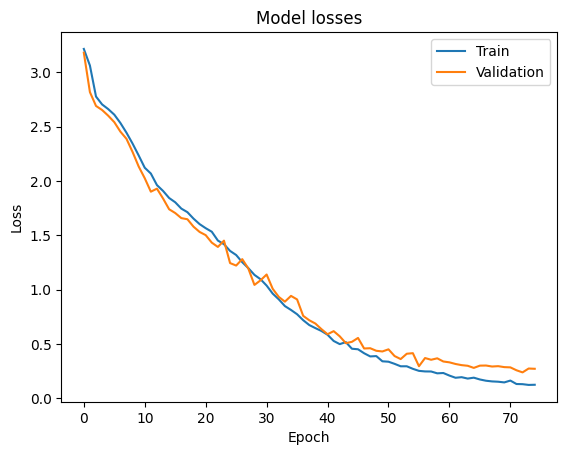

In [12]:
# Model train/val losses
plt.title('Model losses')

plt.plot(train_losses)
plt.plot(val_losses)

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper right')

plt.show()

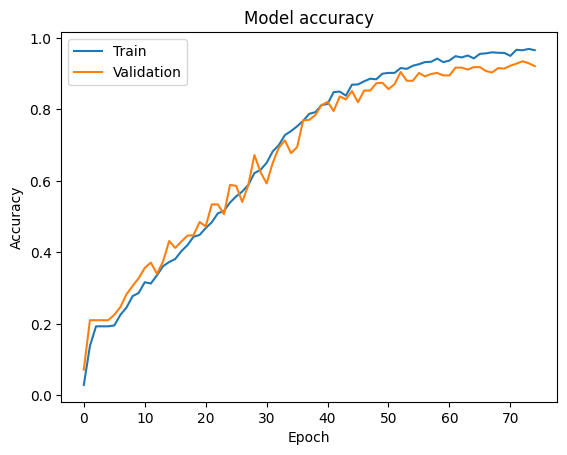

In [13]:
# Model train/val accuracy
plt.title('Model accuracy')

plt.plot(train_accs)
plt.plot(val_accs)

plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [14]:
test_loss, test_acc = test(model, test_loader, criterion)

In [15]:
print('Test loss:', test_loss)
print('Test acc:', test_acc)

Test loss: 0.4006607308173957
Test acc: 0.9035812672176309


In [17]:
scripted_model = torch.jit.script(model)
scripted_model.save('model_T_M.pt')